In [1]:
using Ipaper
using Statistics

using Rasters
using RasterDataSources
using ArchGDAL
using GLMakie
GLMakie.activate!()

using Makie.GeometryBasics
using Makie.GeometryBasics: Tesselation, uv_normal_mesh
using DataInterpolations, Printf


<https://beautiful.makie.org/dev/examples/generated/2d/geo/rasters/#animating-a-3-d-globe>

In [2]:
fs = dir("data/yearly")
rasters = [RasterStack(f) for f in fs]
ra = getproperty.(rasters, :layer1)


20-element Vector{Raster{Float64, 2, Tuple{X{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, X{Colon}}}, Y{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ReverseOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, Y{Colon}}}}, Tuple{Rasters.Band{DimensionalData.Dimensions.LookupArrays.Categorical{Int64, UnitRange{Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrder

In [3]:
# Makie.convert_arguments(Makie.ContinuousSurface(), ra[1])[3]
temp_interpolated = DataInterpolations.QuadraticInterpolation(ra, 1:length(ra), extrapolate=true)   # 插值


40-element QuadraticInterpolation{Vector{Raster{Float64, 2, Tuple{X{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, X{Colon}}}, Y{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ReverseOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, Y{Colon}}}}, Tuple{Rasters.Band{DimensionalData.Dimensions.LookupArrays.Categorical{Int64, UnitRange{Int64}, DimensionalData.Dimensions.Lo

## 1. Figure1

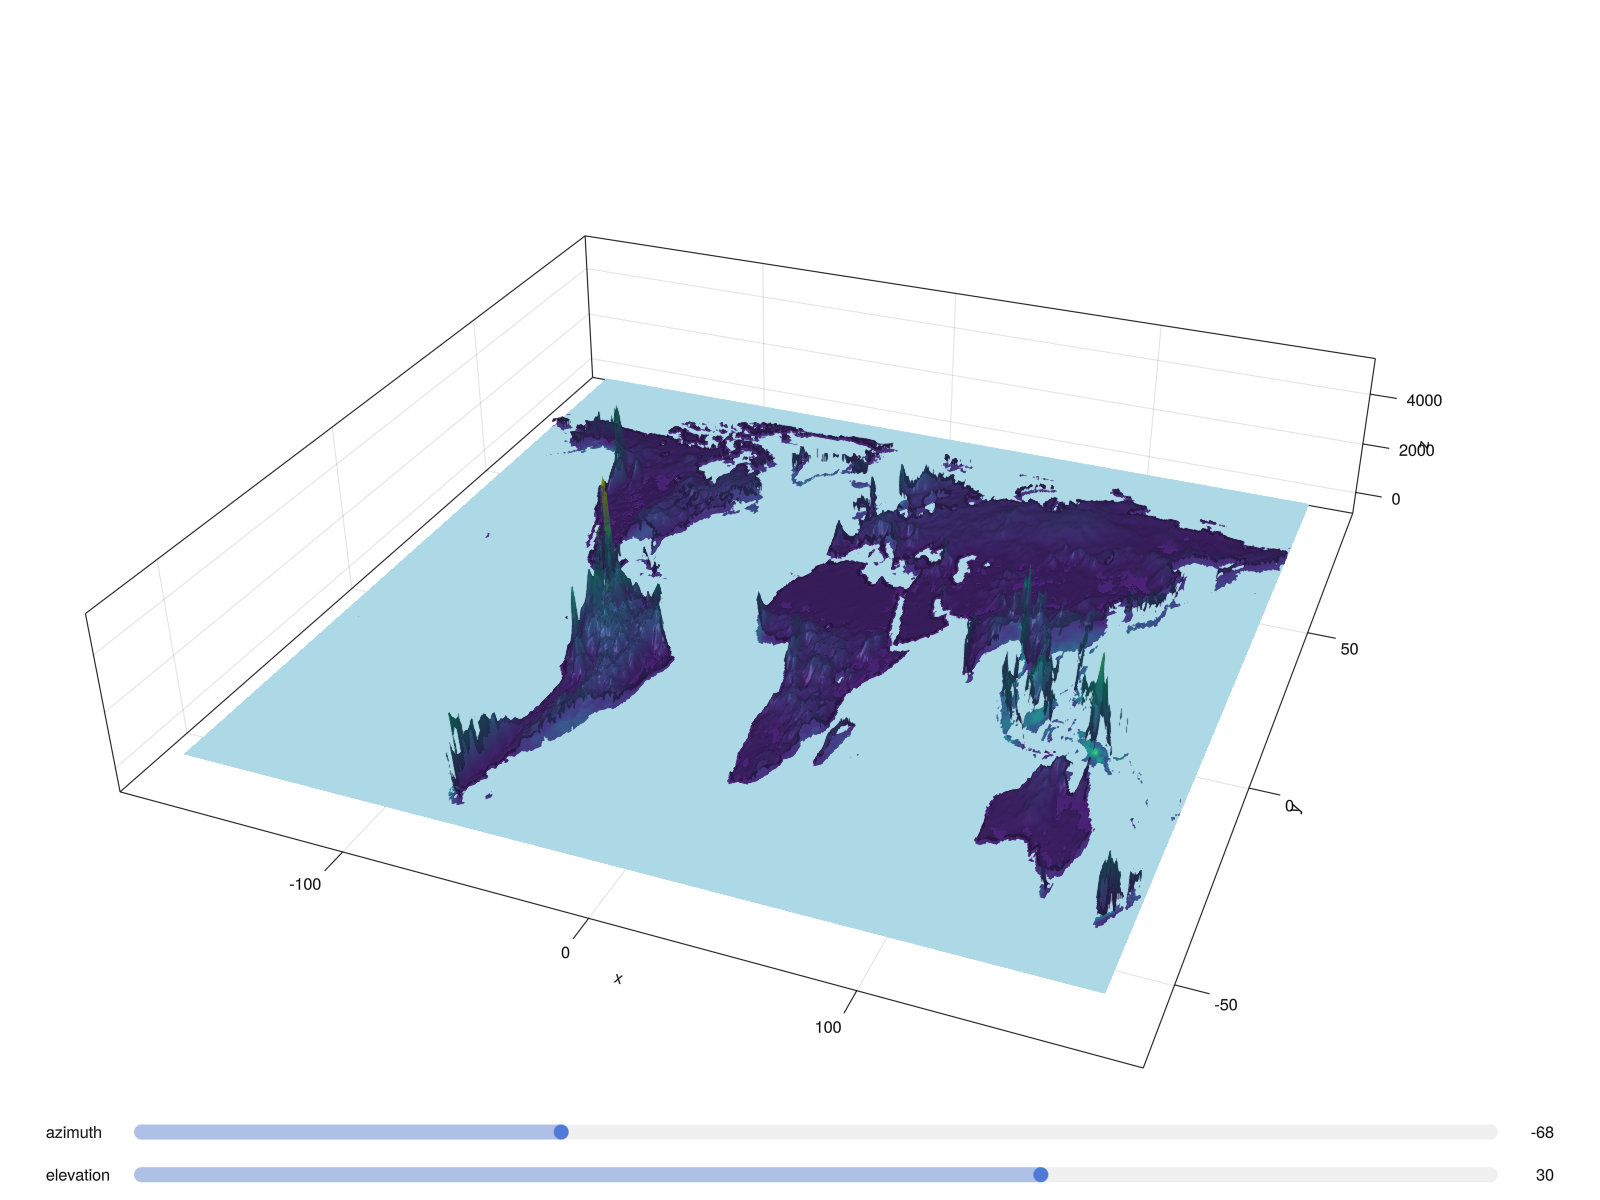

In [4]:
# deg2rad
range_azimuth = (-180:180)
range_elevation = (-90:90)

fig = Figure(resolution=(1600, 1200), outer_padding=2) # figure_padding = 10

sg = SliderGrid(fig[2, 1],
  (label="azimuth", range=range_azimuth, startvalue=-68),
  (label="elevation", range=range_elevation, startvalue=30)
)
sl_azimuth, sl_evev = sg.sliders
azimuth = @lift deg2rad($(sl_azimuth.value))
elev = @lift deg2rad($(sl_evev.value))

# , title="WA Temperature", xlabel="Longitude", ylabel="Latitude"
ax = Axis3(fig[1, 1], perspectiveness=0.5,
  aspect=(1, 1, 0.2),
  azimuth=azimuth,
  elevation=elev)

plt = surface!(ax, temp_interpolated(1.0); transparency=true)
# plt = surface!(ax, temp_interpolated(1.0); 
# axis=(; type=Axis3,
#   perspectiveness=0.5,
#   azimuth=sl_azimuth.value,
#   elevation=sl_evev.value,
#   aspect=(1, 1, 1)),
#   figure=(; resolution=(1600, 1600))
# )
col = "#000000"
hm = heatmap!(ax, temp_interpolated(1.0); nan_color=:lightblue)
translate!(hm, 0, 0, -30) # get the heatmap to the bottom of the plot
fig


In [ ]:
years = 2001:2020

@time record(fig, "wa_surface_animation.mp4", LinRange(1, 12, 480 ÷ 4); framerate=20) do i
  k = floor(Int, i)
  ax.title[] = @sprintf "%d" years[k]
  plt.input_args[1][] = temp_interpolated(i)
  # hm.input_args[1][] = temp_interpolated(i)
end


## 2. Figure2

In [5]:
m = Makie.GeometryBasics.uv_normal_mesh(
  Makie.GeometryBasics.Tesselation(
    Makie.GeometryBasics.Sphere(
      Point3f(0), 1.0f0
    ),
    200
  )
);

p = decompose(Point3f0, m)
uv = decompose_uv(m)
norms = decompose_normals(m);
cmap = [:darkblue, :deepskyblue2, :deepskyblue, :gold, :tomato3, :red, :darkred]


7-element Vector{Symbol}:
 :darkblue
 :deepskyblue2
 :deepskyblue
 :gold
 :tomato3
 :red
 :darkred

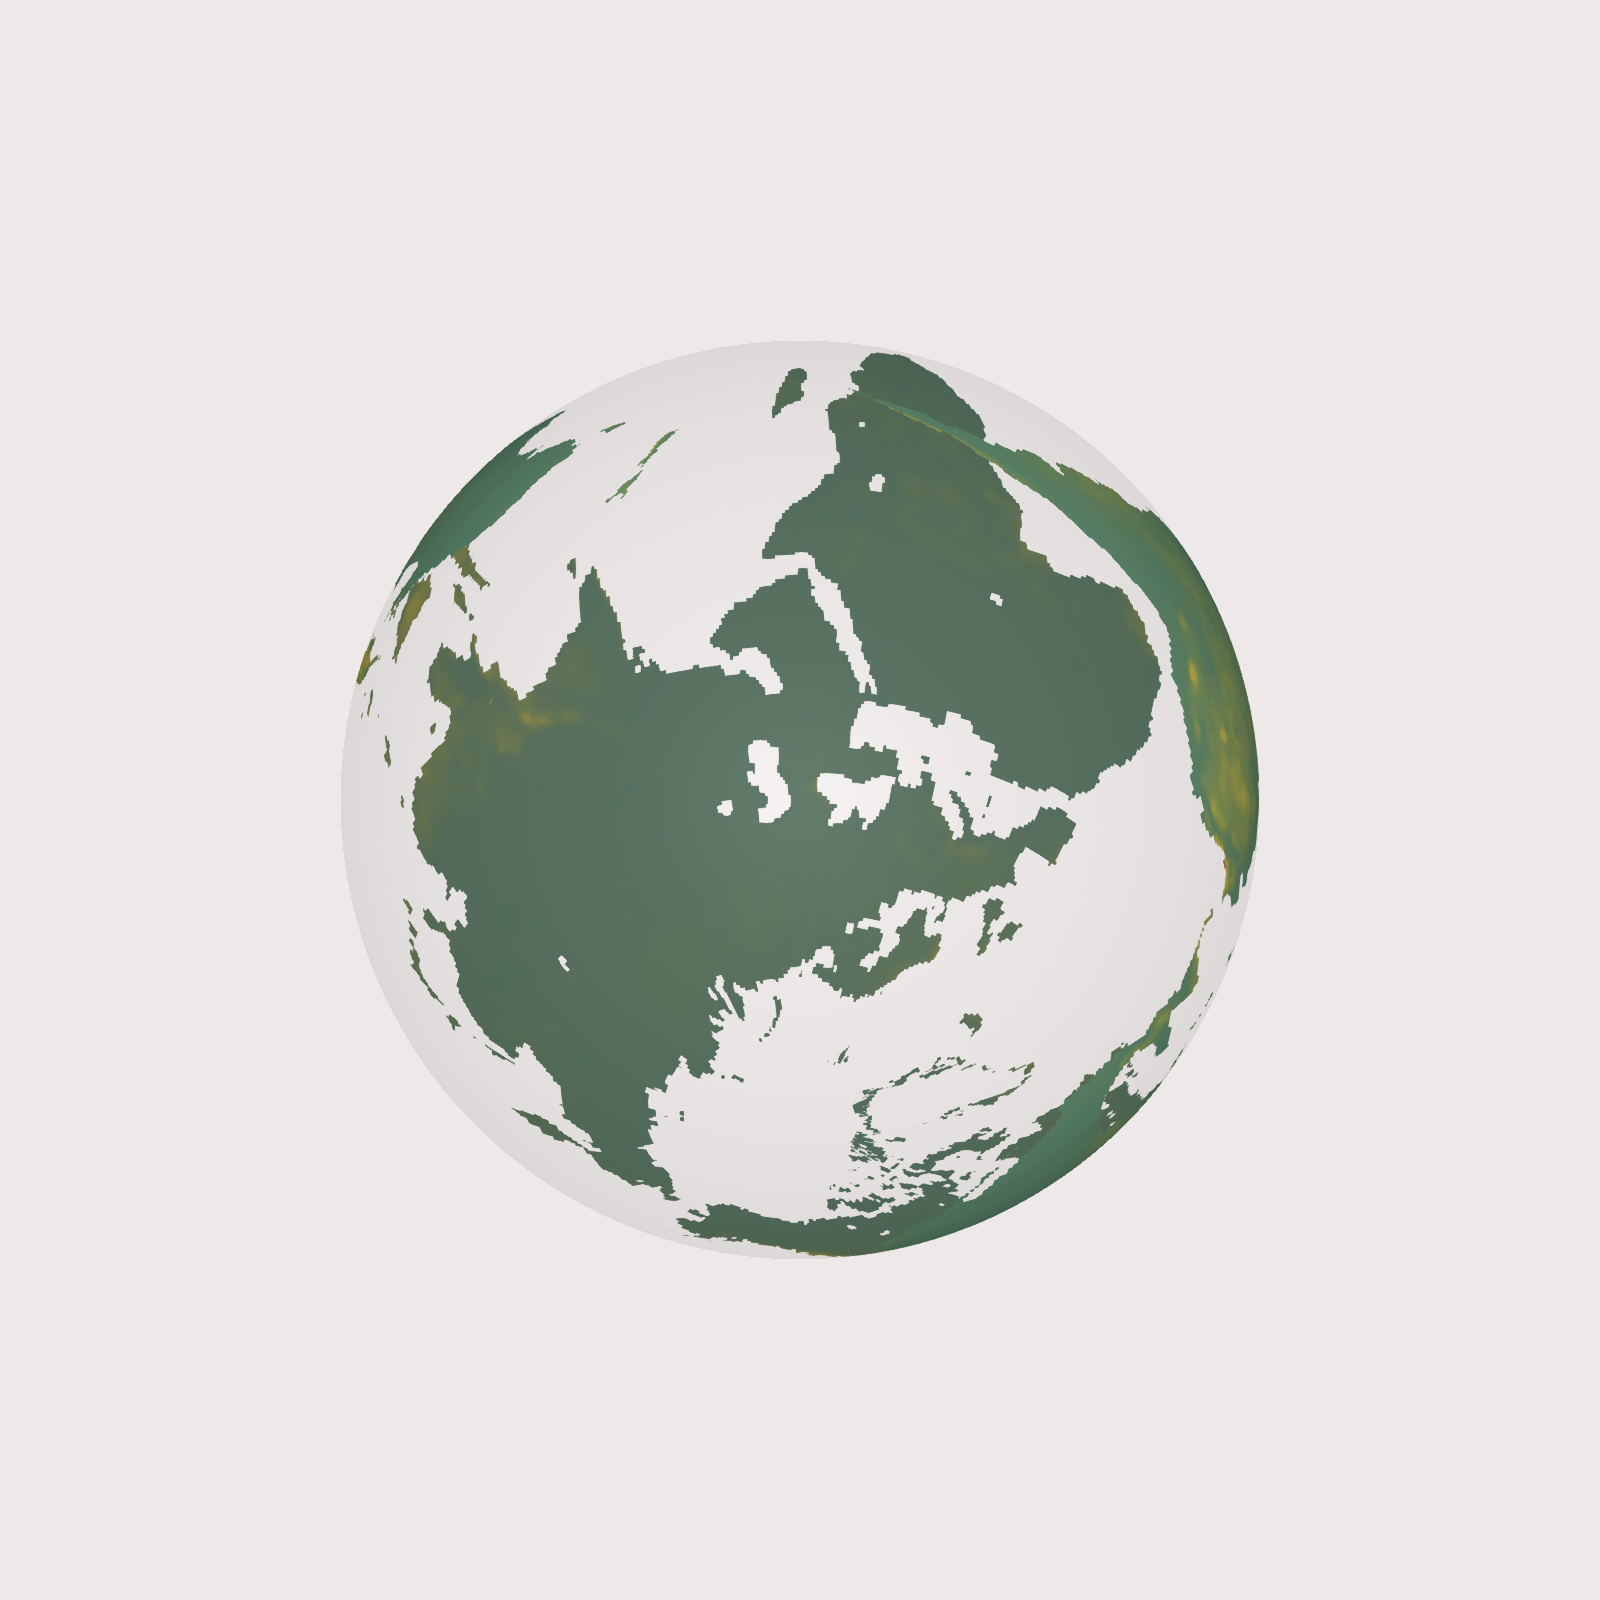

In [6]:
fig = Figure(resolution=(1600, 1600), backgroundcolor=:snow2) # 地图

ax, plt_obj = mesh(fig[1, 1],
  m;
  # uv_normal_mesh(Tesselation(Makie.GeometryBasics.Sphere(Point3f(0), 0.99), 128)),
  color=(:white, 0.1), transparency=true,
  axis=(type=LScene, show_axis=false)
) # 底图+球

temperature_plot = mesh!(fig[1, 1],
  m;
  color=Makie.convert_arguments(Makie.ContinuousSurface(), ra[1])[3]',
  # colorrange=(-0.1, 0.1),
  colormap=:tableau_temperature, #cmap,
  shading=true,
  transparency=false
)    # 地图加球+多年均值      不显示

fig


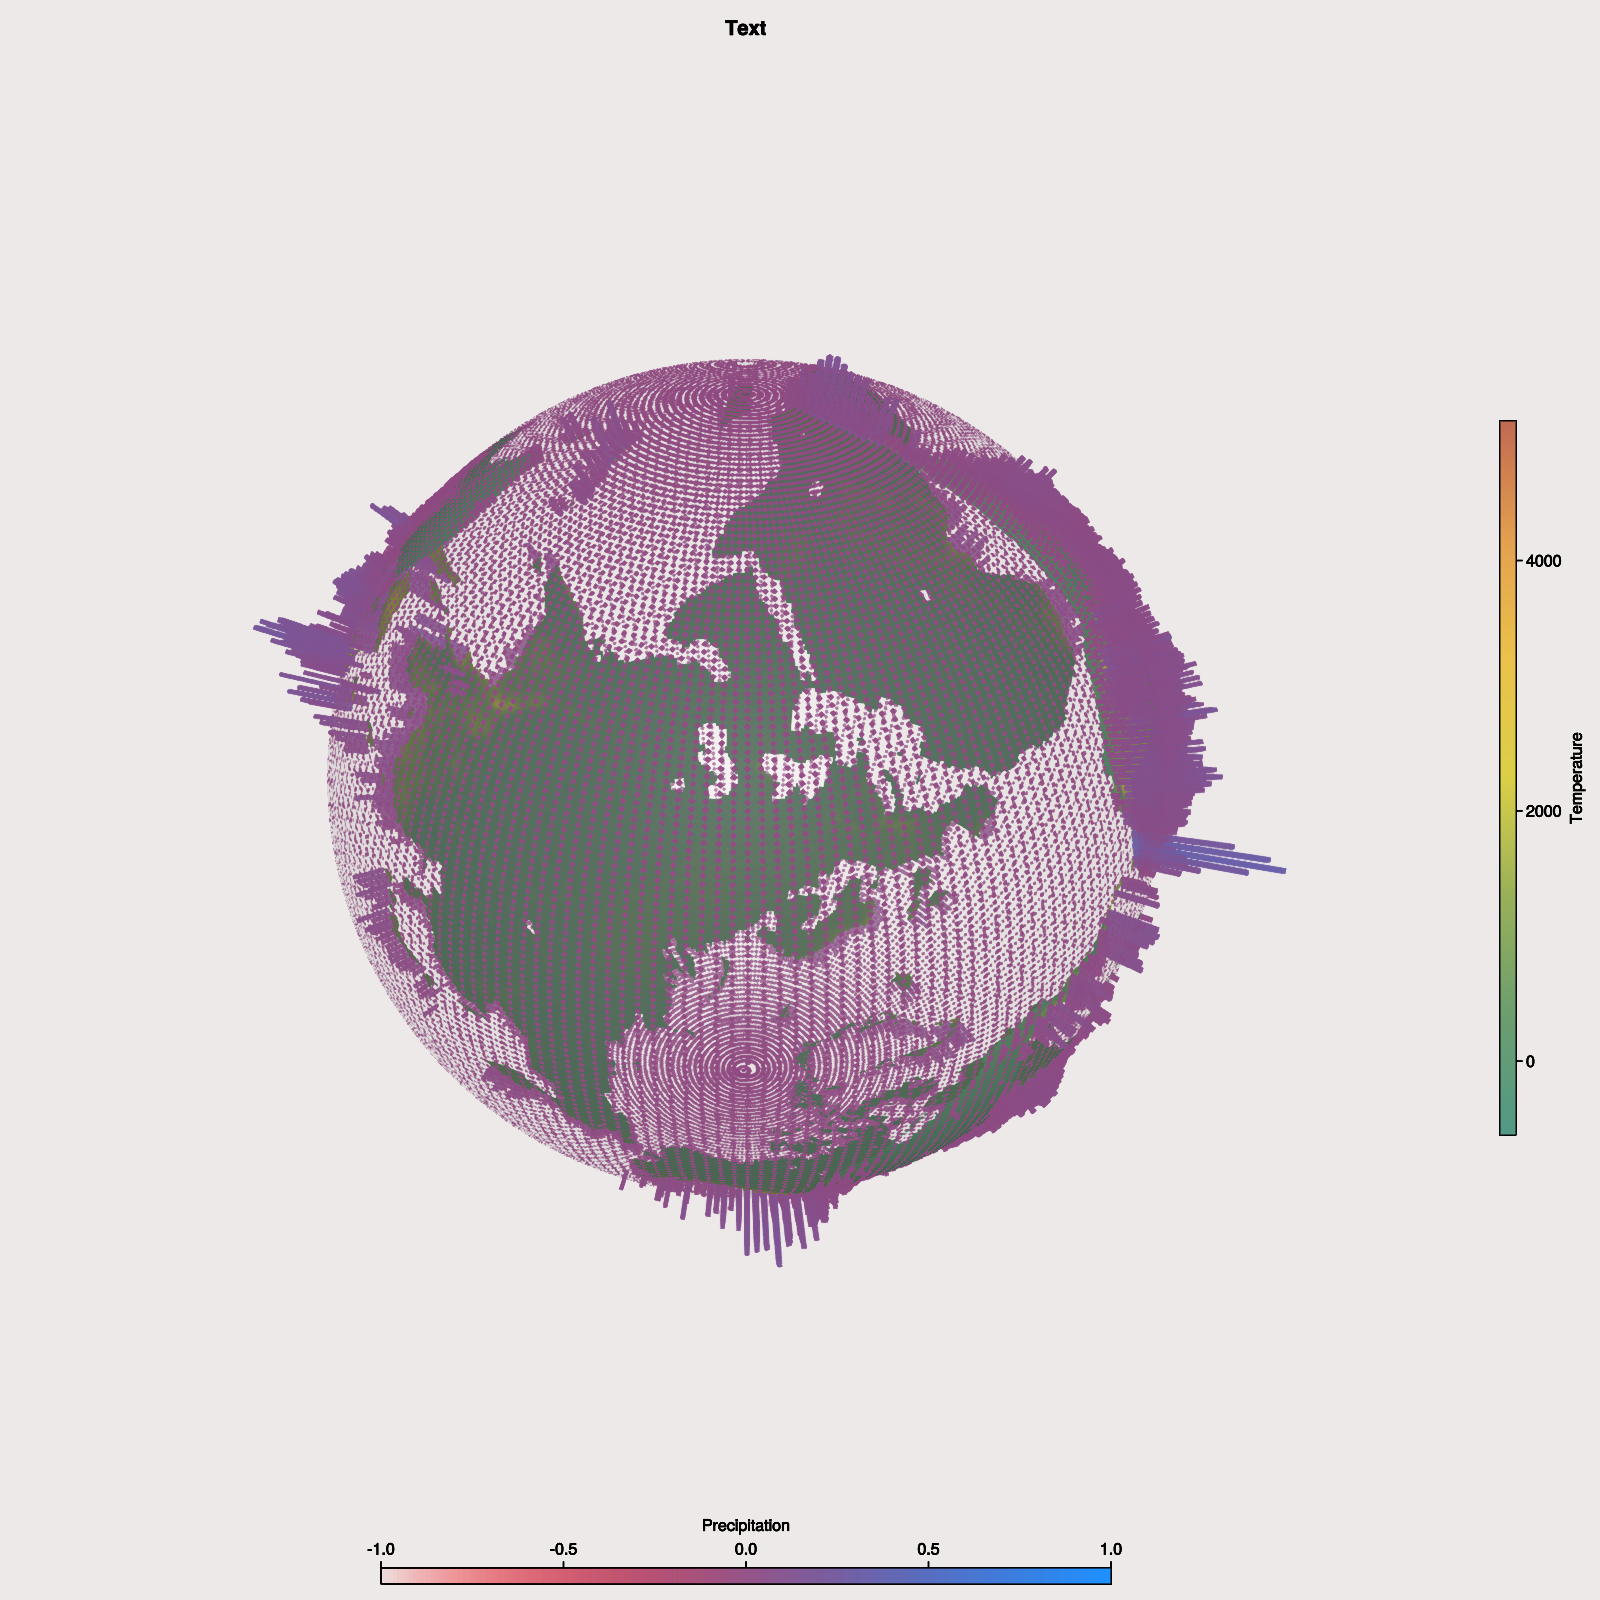

In [16]:
function watermap(uv, water, normalization=908.0f0 * 16.0f0)
  markersize = map(uv) do uv
    wsize = reverse(size(water))
    wh = wsize .- 1
    x, y = round.(Int, Tuple(uv) .* wh) .+ 1
    val = water[size(water)[1]-(y-1), x] / normalization
    (isnan(val) || (val > 50000)) ? -1.0f0 : val
  end
end

raster2array(raster) = Makie.convert_arguments(Makie.ContinuousSurface(), raster)[3]
watervals = watermap(uv, raster2array(ra[1])')

xy_width = 0.01
prec_plot = meshscatter!(
  p, # the positions of the tessellated mesh we got last time
  rotations=norms, # rotate according to the normal vector, pointing out of the sphere
  marker=Rect3(Vec3f(0), Vec3f(1)), # unit box
  markersize=Vec3f0.(xy_width, xy_width, max.(0, watervals)), # scale by 0.01 in x and y, and `watervals` in z
  color=max.(0, watervals),
  colorrange=(-1, 1),
  colormap=[(:red, 0.01), (:dodgerblue, 0.7)],
  shading=false,
  transparency=true,
)

fig


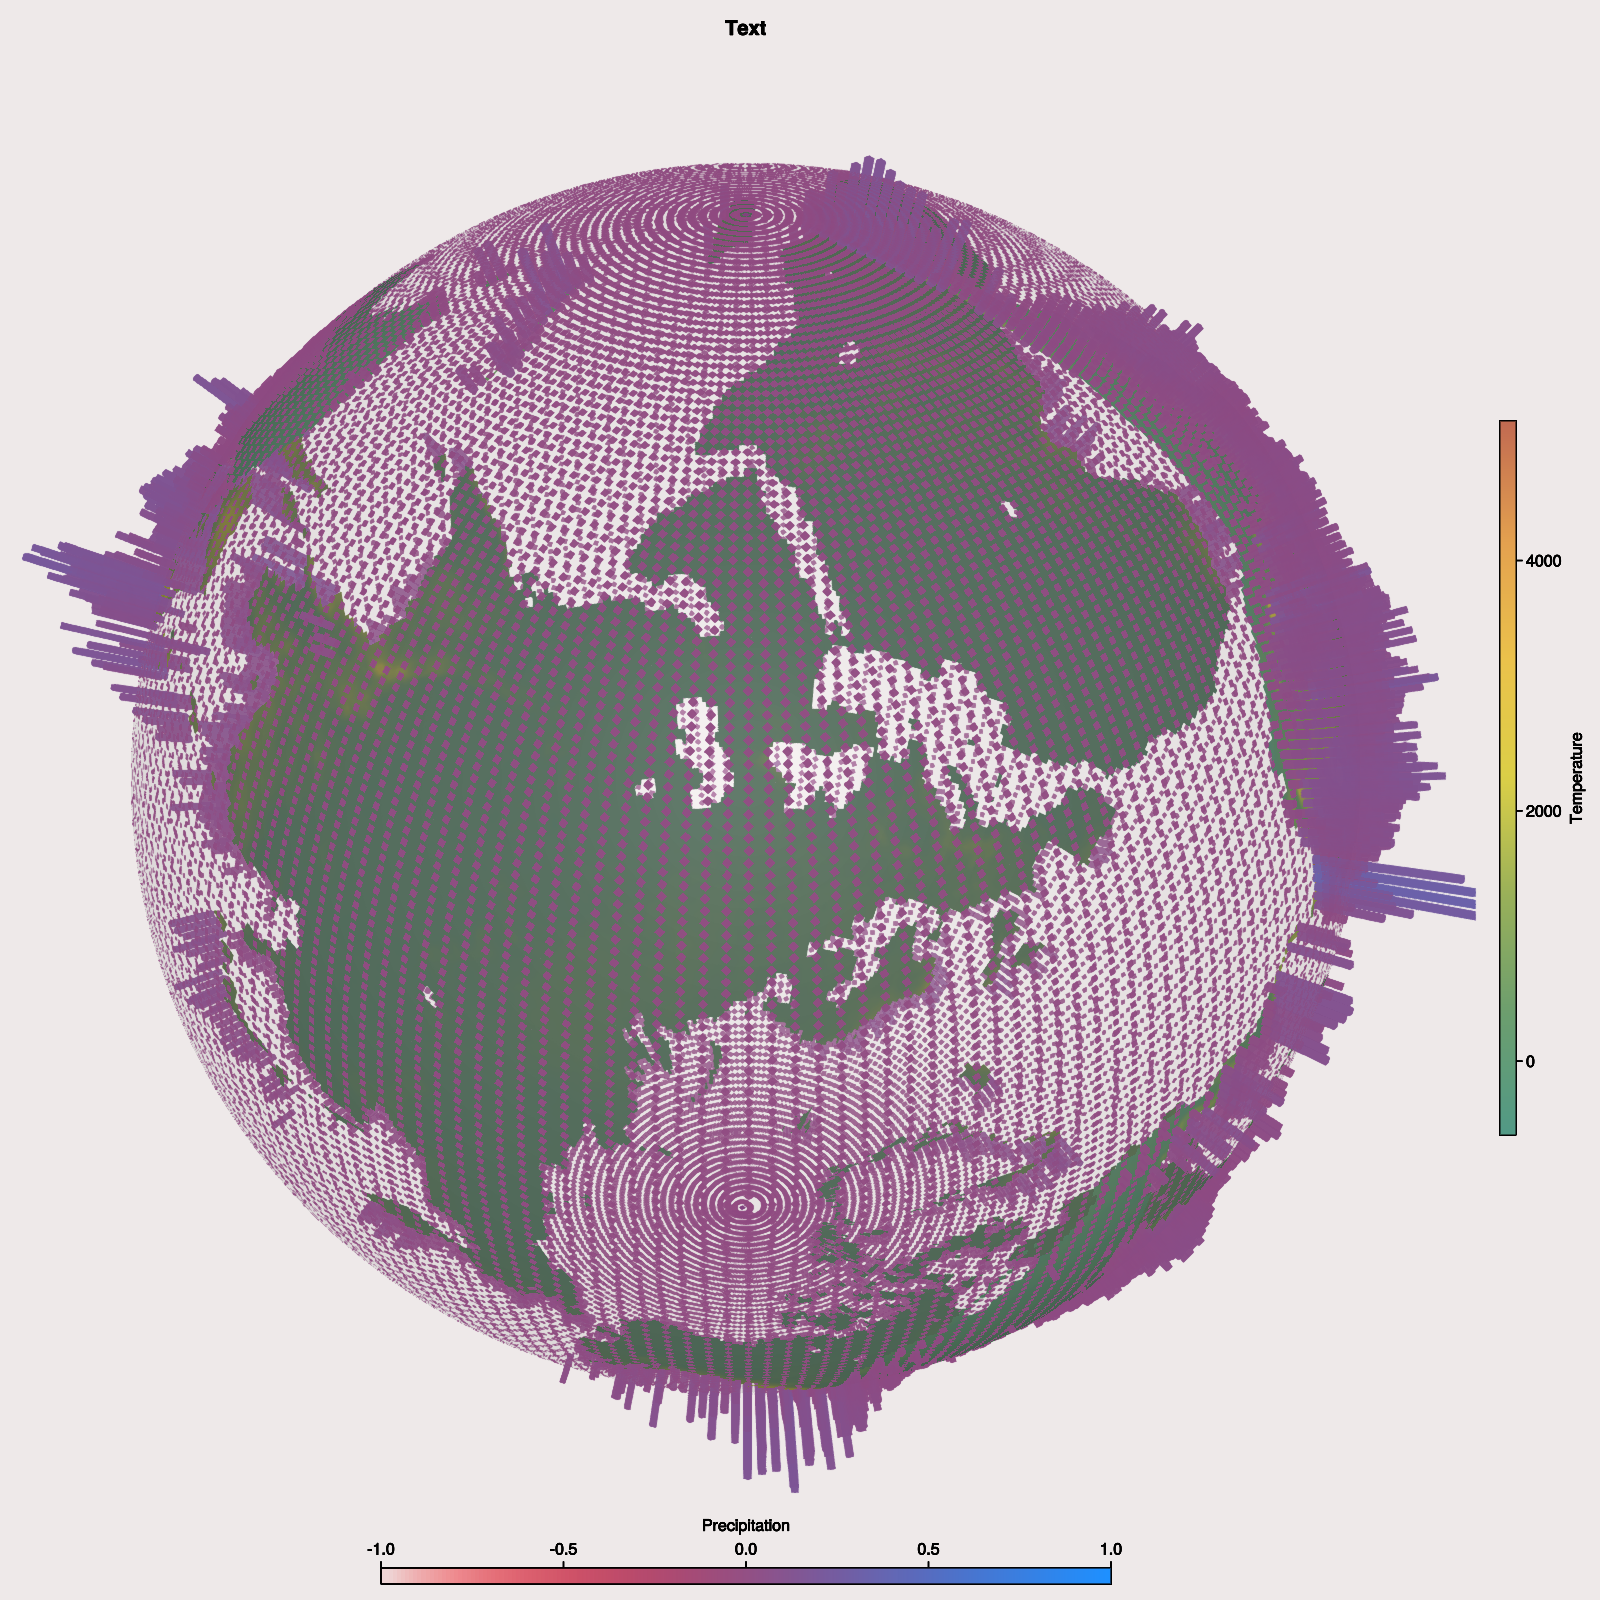

In [17]:
title_label = Label(fig[0, 1]; tellwidth=false, font=:bold, fontsize=20)
Colorbar(fig[1, 2], temperature_plot, label="Temperature", height=Relative(0.5))
Colorbar(fig[2, 1], prec_plot, label="Precipitation", width=Relative(0.5), vertical=false)

zoom!(ax.scene, cameracontrols(ax.scene), 0.7)
fig


In [18]:
record(fig, "wa_visualization.mp4", LinRange(1, 24, 600 ÷ 4); framerate=24) do i
  title_label.text[] = @sprintf "%.2f" (i % 12)

  temperature_plot.color[] = raster2array(temp_interpolated(i % 12))'
  watervals = max.(0, watermap(uv, raster2array(temp_interpolated(i % 12))'))

  prec_plot.color[] = watervals
  prec_plot.markersize[] .= Vec3f0.(xy_width, xy_width, watervals)
  # since we modify markersize inplace above, we need to notify the signal
  rotate!(ax.scene, i / 8)
  notify(prec_plot.markersize)
end;
